**Input**
- PLINK2 GWAS summary statistics
- MAGMA gene analysis results

**Source**
- From Pan-UKBB summary statistics
- From my own GWAS
Both are based on the same data, and therefore must yield the same result

**Phenotype**  
1180 Morning/evening person (chronotype)

**Population**
- Pan-UKBB: EUR (European)
- My own GWAS: White-British

**Process: calculate the following**
- PLINK2
  - Scatter plot of SNP-wise comparison (between Pan-UKBB and my own GWAS)
    - All SNPs
    - Statistically significant SNPs
- MAGMA
  - Adding info
    - Bonferroni-corrected P-values (also written P-Bonf)
    - q-values (also known as FDR-adjusted p-values)
    - Annotation of whether those values are under FDR threshold
  - Scatter plot of SNP-wise comparison (between Pan-UKBB and my own GWAS)
    - All SNPs
    - Statistically significant SNPs

# Preparation (Execute all in this section!)

## Import libraries & set environment variables

In [1]:
import collections
from datetime import datetime
import os
import numpy as np
from pathlib import Path
import polars as pl
import re
import textwrap

import warnings
# suppress DeprecationWarning messages
warnings.filterwarnings("ignore", category=DeprecationWarning)

from matplotlib import pyplot as plt
from matplotlib_venn import venn2
from matplotlib_venn import venn3

dir_home = Path(os.getcwd()).parent.parent.parent
os.chdir(dir_home)
print("Current directory (check that it's your home directory):", os.getcwd())

Current directory (check that it's your home directory): J:\sugai\UKBiobank


## File I/O

In [24]:
# Input: MAGMA result from Pan-UKBB
FILE_SOURCE_PANUKBB = os.path.join("analysis", 
                                   "panukbb_magma",
                                   "continuous-1180-both_sexes",
                                   "out.with_gene_name.txt")

# Input: MAGMA result from my own GWAS
# 1: based on raw P-values in GWAS
FILE_SOURCE_MYGWAS_1 = os.path.join("analysis", 
                                  "specific",
                                  "analysis_20230428_01_gwas_chronotype",
                                  "magma",
                                  "out.with_gene_name.txt")
# 2: based on Bonferroni-corrected P-values in GWAS
FILE_SOURCE_MYGWAS_2 = os.path.join("analysis", 
                                  "specific",
                                  "analysis_20230501_01_gwas_chronotype",
                                  "magma",
                                  "out.with_gene_name.txt")

# Input: PLINK result from my own GWAS
FILE_SUMSTAT_MYGWAS_1 = os.path.join("analysis", 
                                  "specific",
                                  "analysis_20230428_01_gwas_chronotype",
                                  "pval_for_magma.txt")

# Input: Pan-UKBB summary statistics
FILE_SUMSTAT_PANUKBB = os.path.join("data", 
                                    "panukbb",
                                    "for_magma",
                                    "per_phenotype",
                                    "continuous-1180-both_sexes.tsv"
                                   )


# Output folder
DIR_OUT = os.path.join("analysis", "specific", "analysis_20230502_01_sleep_GWAS_comparison")
if not os.path.exists(DIR_OUT):
    os.makedirs(DIR_OUT)

# Intermediate output: added info
#     (q-values and statistically significant genes)
FILE_ANNOTATED_PANUKBB = os.path.join(DIR_OUT, "out.with_p_correction_PanUKBB.csv")
FILE_ANNOTATED_MYGWAS_1 = os.path.join(DIR_OUT, "out.with_p_correction_myGWAS_1.csv")
FILE_ANNOTATED_MYGWAS_2 = os.path.join(DIR_OUT, "out.with_p_correction_myGWAS_2.csv")

FDR_THRESHOLD = 0.05 # Q value threshold

## Functions

In [3]:
def flatten(l):
    for el in l:
        if isinstance(el, collections.abc.Iterable) and not isinstance(el, (str, bytes)):
            yield from flatten(el)
        else:
            yield el


def func_print(i):
    if i < 10 or str(i)[1:].count('0') == len(str(i))-1:
        now = datetime.now()
        print(f"{now.strftime('%Y-%m-%d %H:%M:%S')}: {i}")
        

def func_process(FILE_SOURCE, FILE_OUTPUT):
    # Read as String to avoid any automatic conversion
    df = (pl.read_csv(FILE_SOURCE, 
                      separator=" ", 
                      infer_schema_length=0)
          .with_columns(pl.col("P").cast(pl.Float32).alias("P_Bonf"))
          .with_columns(pl.col("P").cast(pl.Float32).alias("P_log10"))
          .with_columns(pl.col("P").cast(pl.Float32).alias("Q"))
          .with_columns(np.log10(pl.col("P_log10")))
          .sort(by='Q'))

    n_count = df['Q'].is_not_null().sum()

    df = (df
          # Calculate Bonferroni-corrected P values
          .with_columns(pl.col('P_Bonf') * n_count)
           # create a new column which is true if "P_Bonf" is under threshold
          .with_columns((pl.col("P_Bonf") < FDR_THRESHOLD).alias("Positive_P_Bonf"))
          # Calculate Q values
          # Multiply Q column by number of non-null values
          .with_columns(pl.col('Q') * n_count)
          # # Divide the Q columns by the rank of individual value among all the non-null values
          .with_columns(pl.col('Q') / df['Q'].rank())
          # create a new column which is true if "q" is under threshold
          .with_columns((pl.col("Q") < FDR_THRESHOLD).alias("Positive_Q"))
          # Add log10 values
          .with_columns(pl.col("P_Bonf").alias("P_Bonf_log10"))
          .with_columns(np.log10(pl.col("P_Bonf_log10")))
          .with_columns(pl.col("Q").alias("Q_log10"))
          .with_columns(np.log10(pl.col("Q_log10")))
          # Sort
          .sort(by='Positive_P_Bonf', descending=True)
         )

    df.write_csv(FILE_OUTPUT)
    
def func_list_genes(file_source):
    df_all = pl.read_csv(file_source, separator=",")
    df_positive = df_all.filter(pl.col("Positive_P_Bonf"))
    set_genes_all = set(df_all["NAME"])
    set_genes_positive = set(df_positive["NAME"])
    print("All =", len(set_genes_all), "genes, positive =", len(set_genes_positive), "genes")
    return set_genes_all, set_genes_positive

# Process summary statistics

In [29]:
df_sumstat_mygwas = (pl.read_csv(FILE_SUMSTAT_MYGWAS_1, 
                                 separator=" ", 
                                 infer_schema_length=0)
                     .with_columns(pl.col("P").cast(pl.Float64))
                     .rename({"P": "P_MyGWAS"})
     )

df_sumstat_panukbb = (pl.read_csv(FILE_SUMSTAT_PANUKBB, 
                                  separator=" ", 
                                  infer_schema_length=0)
                      .with_columns(pl.col("P").cast(pl.Float64))
                      .rename({"P": "P_PanUKBB"})
     )

df_sumstat_comparison = df_sumstat_mygwas.join(df_sumstat_panukbb, 
                                               on="SNP", how="inner")

In [91]:
print(df_sumstat_mygwas.shape[0])
print(df_sumstat_mygwas.head())
print()

print(df_sumstat_panukbb.shape[0])
print(df_sumstat_panukbb.head())
print()

print(df_sumstat_comparison.shape[0])
print(df_sumstat_comparison.head())

9437885
shape: (5, 2)
┌──────────────────────┬────────────┐
│ SNP                  ┆ P_MyGWAS   │
│ ---                  ┆ ---        │
│ str                  ┆ f64        │
╞══════════════════════╪════════════╡
│ 1:182573227[b37]T,C  ┆ 3.4122e-17 │
│ 1:182569626[b37]T,C  ┆ 4.0844e-17 │
│ 1:182553693[b37]C,T  ┆ 5.3722e-17 │
│ 1:182558139[b37]G,T  ┆ 5.5576e-17 │
│ 1:182548483[b37]GC,G ┆ 5.6884e-17 │
└──────────────────────┴────────────┘

28987534
shape: (5, 2)
┌─────────────────┬───────────┐
│ SNP             ┆ P_PanUKBB │
│ ---             ┆ ---       │
│ str             ┆ f64       │
╞═════════════════╪═══════════╡
│ 1:11063[b37]T,G ┆ 0.459304  │
│ 1:13259[b37]G,A ┆ 0.0261216 │
│ 1:17641[b37]G,A ┆ 0.950036  │
│ 1:30741[b37]C,A ┆ 1.0       │
│ 1:51427[b37]T,G ┆ 1.0       │
└─────────────────┴───────────┘

9275437
shape: (5, 3)
┌──────────────────┬──────────┬───────────┐
│ SNP              ┆ P_MyGWAS ┆ P_PanUKBB │
│ ---              ┆ ---      ┆ ---       │
│ str              ┆ f64     

## Compare P-values

Corr = 0.5567517273136411


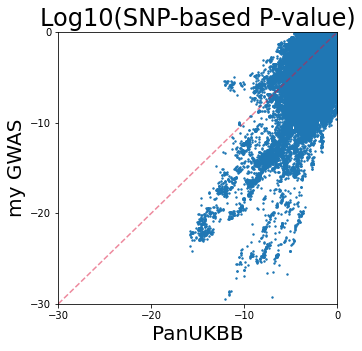

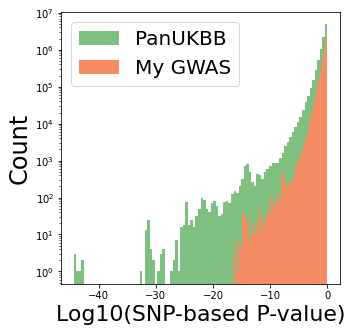

In [101]:
# Scatter plot
fig, ax = plt.subplots(figsize=[5, 5])
x = df_sumstat_comparison["P_MyGWAS"].to_numpy()
y = df_sumstat_comparison["P_PanUKBB"].to_numpy()
x = np.log10(x)
y = np.log10(y)

print("Corr =", np.corrcoef(x, y)[0, 1])

ax.scatter(x, y, s=2)
line1, = ax.plot(np.linspace(-30, 0, 10), np.linspace(-30, 0, 10),
                linestyle="dashed", color = "crimson", alpha = 0.5,)

ax.set_xlim(-30, 0)
ax.set_ylim(-30, 0)
ax.set_xticks([-30, -20, -10, 0]) 
ax.set_yticks([-30, -20, -10, 0]) 

ax.set_xlabel("PanUKBB", fontsize=20)
ax.set_ylabel("my GWAS", fontsize=20)
ax.set_title("Log10(SNP-based P-value)", fontsize=24)
plt.show()

fig, ax = plt.subplots(figsize=[5, 5])
ax.set_xlabel("Log10(SNP-based P-value)", fontsize=22)
ax.set_ylabel("Count", fontsize=24)
ax.set_yscale('log')
ax.hist(y,
        alpha=0.5, label="PanUKBB", density=False, bins=100, color="green")
ax.hist(x,
        alpha=1, label="My GWAS", density=False, bins=100, color='#f48d63')
ax.legend(fontsize=20)

plt.show()

# Process MAGMA results

## Add Pbonf, q-values, posi/nega annotation

In [42]:
func_process(FILE_SOURCE_MYGWAS_1, FILE_ANNOTATED_MYGWAS_1)
func_process(FILE_SOURCE_MYGWAS_2, FILE_ANNOTATED_MYGWAS_2)
func_process(FILE_SOURCE_PANUKBB, FILE_ANNOTATED_PANUKBB)

G:\linux\conda\envs\py3-202304\lib\site-packages\polars\series\series.py:981: RuntimeWarning: divide by zero encountered in log10
  series = f(lambda out: ufunc(*args, out=out, dtype=dtype_char, **kwargs))


## List up the genes

In [43]:
print("My GWAS - raw P-values")
set_genes_all_mygwas_1, set_genes_positive_mygwas_1 = \
func_list_genes(FILE_ANNOTATED_MYGWAS_1)
print()

print("My GWAS - Bonferroni-corrected P-values")
set_genes_all_mygwas_2, set_genes_positive_mygwas_2 = \
func_list_genes(FILE_ANNOTATED_MYGWAS_2)
print()

print("Pan-UKBB")
set_genes_all_panukbb, set_genes_positive_panukbb = \
func_list_genes(FILE_ANNOTATED_PANUKBB)

My GWAS - raw P-values
All = 19427 genes, positive = 37 genes

My GWAS - Bonferroni-corrected P-values
All = 19427 genes, positive = 2 genes

Pan-UKBB
All = 19427 genes, positive = 270 genes


## Draw Venn diagrams

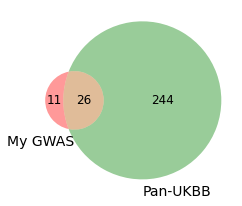

In [54]:
# Draw Venn diagrams - 2 sets
def func_venn2(set_genes_1, set_genes_2, list_names):
    plt.rcParams["figure.figsize"] = [3.5, 3.5]
    plt.rcParams["figure.autolayout"] = True

    out = venn2(
        [set_genes_1, set_genes_2], 
          list_names
               )
    
    for text in out.set_labels:
        text.set_fontsize(14)
    try: # Sometimes it fails because no intersect exists
        for text in out.subset_labels:
            text.set_fontsize(12)
    except:
        pass
    plt.show()

func_venn2(set_genes_positive_mygwas_1, set_genes_positive_panukbb, ["My GWAS", "Pan-UKBB"])

## Compare P-values

In [45]:
df_genebased_mygwas = pl.read_csv(FILE_ANNOTATED_MYGWAS_1, separator=",")
df_genebased_panukbb = pl.read_csv(FILE_ANNOTATED_PANUKBB, separator=",")

# Extract columns "NAME" and "P" from df_mygwas
df_genebased_mygwas = df_genebased_mygwas.select(["NAME", "P_log10"]).rename({"P_log10": "Log10P_mygwas"})

# Extract columns "NAME" and "P" from df_panukbb
df_genebased_panukbb = df_genebased_panukbb.select(["NAME", "P_log10"]).rename({"P_log10": "Log10P_panukbb"})

# Merge the two DataFrames based on "NAME" column
df_merged = df_genebased_mygwas.join(df_genebased_panukbb, on="NAME", how="inner").drop_nulls()

Corr = 0.5970679302923951


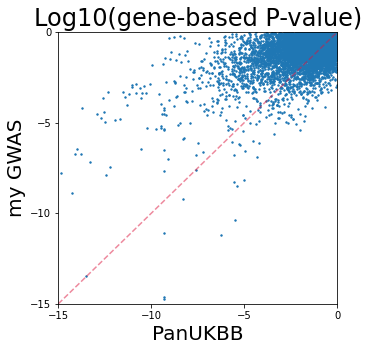

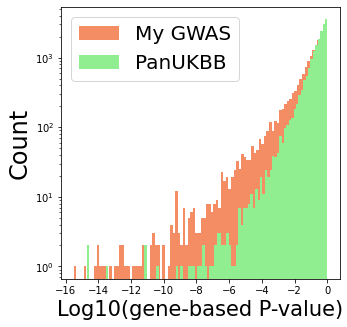

In [100]:
x = df_merged["Log10P_panukbb"].to_numpy()
y = df_merged["Log10P_mygwas"].to_numpy()

print("Corr =", np.corrcoef(x, y)[0, 1])

# Create scatter plot
fig, ax = plt.subplots(figsize=[5, 5])
ax.scatter(x, y, s=2)
line1, = ax.plot(np.linspace(-15, 0, 10), np.linspace(-15, 0, 10),
                linestyle="dashed", color = "crimson", alpha = 0.5,)

ax.set_xlim(-15, 0)
ax.set_ylim(-15, 0)
ax.set_xticks([-15, -10, -5, 0]) 
ax.set_yticks([-15, -10, -5, 0]) 

ax.set_xlabel("PanUKBB", fontsize=20)
ax.set_ylabel("my GWAS", fontsize=20)
ax.set_title("Log10(gene-based P-value)", fontsize=24)
plt.show()

fig, ax = plt.subplots(figsize=[5, 5])
ax.set_xlabel("Log10(gene-based P-value)", fontsize=21)
ax.set_ylabel("Count", fontsize=24)
ax.set_yscale('log')
ax.hist(x,
        alpha=1, label="My GWAS", density=False, bins=100, color='#f48d63')
ax.hist(y,
        alpha=1, label="PanUKBB", density=False, bins=100, color="lightgreen")
ax.legend(fontsize=20)

plt.show()

In [99]:
x = df_merged["Log10P_panukbb"].to_numpy()
y = df_merged["Log10P_mygwas"].to_numpy()
np.corrcoef(x, y)[0, 1]

0.5970679302923951